# Power Dissipation Index (PDI) Analysis

PDI is an index that represents the destructive power of a storm combining together, intensity, duration, and frequency.

References: [Emanuel, 2005](ftp://texmex.mit.edu/pub/emanuel/PAPERS/NATURE03906.pdf) and [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf)

In the references, Kerry Emanuel defines the index as:

$$PDI\equiv\int_0^{\tau}V^3_{max}dt~,$$

where $V_{max}$ is the maximum sustained wind speed, and $\tau$ is the lifetime of the storm event.

We're gonna use the PDI calculated by [National Oceanic & Atmospheric Administration (NOAA)](https://www.noaa.gov) which data is avaible at [Our World in Data](https://ourworldindata.org/grapher/cyclone-power-dissipation-index). It covers the North Atlantic, Caribbean and Gulf of Mexico storms.

The data has been smoothed through a five-year weighted average plotted at the center, in order to remove interannual variability. We're gonna o the same smooth with our climate dataset of Atlantic MDR.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [11]:
raw_pdi = pd.read_csv('Datasets/cyclone-power-dissipation-index.csv')
raw_pdi

,Entity,Code,Year,"Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)"
0,North Atlantic,NaN,1951,2.7846
1,North Atlantic,NaN,1952,2.3445
2,North Atlantic,NaN,1953,2.2639
3,North Atlantic,NaN,1954,2.4730
4,North Atlantic,NaN,1955,2.4041
...,...,...,...,...
58,North Atlantic,NaN,2009,3.0860
59,North Atlantic,NaN,2010,3.2155
60,North Atlantic,NaN,2011,3.0646
61,North Atlantic,NaN,2012,2.4496


In [18]:
raw_pdi.dtypes

Entity                                                   object
Code                                                    float64
Year                                                      int64
Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)    float64
dtype: object

In [28]:
PDI = raw_pdi[['Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)']].rename(
    columns={'Year': 'Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)':'PDI'})
PDI

,Year,PDI
0,1951,2.7846
1,1952,2.3445
2,1953,2.2639
3,1954,2.4730
4,1955,2.4041
...,...,...
58,2009,3.0860
59,2010,3.2155
60,2011,3.0646
61,2012,2.4496


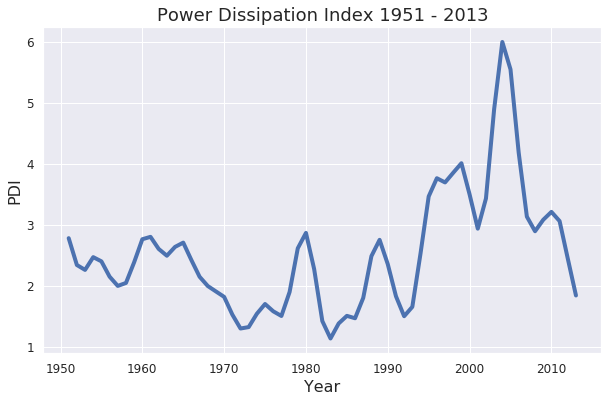

In [51]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("Power Dissipation Index 1951 - 2013",fontsize = 18)
plt.ylabel("PDI",fontsize = 16)
plt.xlabel("Year",fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.plot(PDI.Year,PDI.PDI,lw = 4);